## Solution of a Damped Driven Pendulum using a Kolmogorov-Arnold Network (KAN)

***Author: Brandon I. (brandon.ismalej.671@my.csun.edu)***

 NOTE: This notebook was written as a part of my assigned research duty and will be used as a component in the final deliverable. 

## Introduction

This notebook explores the solution of a driven damped pendulum using a Kolmogorov-Arnold Network (KAN).
This notebook aims to provide supporting data on the accuracy on the implementation of a Physics-Informed Neural Network (PINN) using a KAN, in comparison with other methods, such as a Mutil-Layer Perceptrons (MLPs) and other traditional ordinary differential equation (ODE) solvers like SciPy. 

In [72]:
# The following Python libraries must be installed before attempting to run the contents on this notebook.
# pip install pykan torch numpy matplotlib scikit-learn tqdm


In [73]:
from kan import *
import torch
import torch as nn
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

In [74]:
# Initialize Constants
Omega = 2 * np.pi # Driving frequency
omega = Omega * 1.5 # Natural frequency
lambda_ = omega / 2 # Damping coefficient
gamma = 0.8 # Driving strength

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the driven damped pendulum differential equation
def driven_damped_pendulum(t, y, omega, lambda_, gamma, Omega):
    theta, omega_dot = y
    dydt = [omega_dot, -lambda_ * omega_dot - omega**2 * np.sin(theta) + gamma * np.cos(Omega * t)]
    return dydt

# Initial conditions
y0 = [0.0, 0.0]

# Time points
t = np.linspace(0, 10, 1000)

# Solve the differential equation using solve_ivp
sol = solve_ivp(driven_damped_pendulum, [t[0], t[-1]], y0, args=(omega, lambda_, gamma, Omega), t_eval=t)



In [76]:
import torch
import torch.nn as nn

# Define the KAN model
class KAN(nn.Module):
    def __init__(self):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(1,100)   #(1, 50)
        self.fc2 = nn.Linear(100,100)   #(50, 50)
        self.fc3 = nn.Linear(100,1)   #(50, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [77]:

# Instantiate the model, define the loss function and optimizer
kan_model = KAN()
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.001)

# Generate training data
t_train = torch.tensor(t, dtype=torch.float32).view(-1, 1)
t_train.requires_grad = True 
y_train = torch.tensor(sol.y[0], dtype=torch.float32).view(-1, 1)

In [78]:
# Define the loss functions
def domain_loss(model, t_train, y_train):
    y_pred = model(t_train)
    dy_pred = torch.autograd.grad(y_pred, t_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    d2y_pred = torch.autograd.grad(dy_pred, t_train, grad_outputs=torch.ones_like(dy_pred), create_graph=True)[0]
    equation = d2y_pred + lambda_ * dy_pred + omega**2 * torch.sin(y_pred) - gamma * torch.cos(Omega * t_train)
    loss = torch.mean(equation**2)
    return loss

In [79]:

def boundary_loss(model, t_train, y_train):
    y_pred = model(t_train)
    boundary_values = y_train[0]  # Assuming initial boundary condition y(0) = 0
    loss = torch.mean((y_pred[0] - boundary_values)**2)
    return loss

In [80]:

omega_D = 1.0
omega_B = 1.0

In [81]:

# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    domain_loss_value = domain_loss(kan_model, t_train, y_train)
    boundary_loss_value = boundary_loss(kan_model, t_train, y_train)
    loss = omega_D * domain_loss_value + omega_B * boundary_loss_value
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [500/20000], Loss: 0.2430
Epoch [1000/20000], Loss: 0.2201
Epoch [1500/20000], Loss: 0.2156
Epoch [2000/20000], Loss: 0.2143
Epoch [2500/20000], Loss: 0.2118
Epoch [3000/20000], Loss: 0.2110
Epoch [3500/20000], Loss: 0.2093
Epoch [4000/20000], Loss: 0.2076
Epoch [4500/20000], Loss: 0.2333
Epoch [5000/20000], Loss: 0.2144
Epoch [5500/20000], Loss: 0.2032
Epoch [6000/20000], Loss: 0.2027
Epoch [6500/20000], Loss: 0.2016
Epoch [7000/20000], Loss: 0.1985
Epoch [7500/20000], Loss: 0.1962
Epoch [8000/20000], Loss: 0.4072
Epoch [8500/20000], Loss: 0.1927
Epoch [9000/20000], Loss: 0.1896
Epoch [9500/20000], Loss: 0.1955
Epoch [10000/20000], Loss: 0.2148
Epoch [10500/20000], Loss: 0.1817
Epoch [11000/20000], Loss: 0.2396
Epoch [11500/20000], Loss: 0.1748
Epoch [12000/20000], Loss: 0.1711
Epoch [12500/20000], Loss: 0.1673
Epoch [13000/20000], Loss: 0.1653
Epoch [13500/20000], Loss: 0.1624
Epoch [14000/20000], Loss: 0.3125
Epoch [14500/20000], Loss: 0.1638
Epoch [15000/20000], Loss: 0.1749


In [82]:
# Predict using the KAN model
t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
y_kan = kan_model(t_test).detach().numpy()

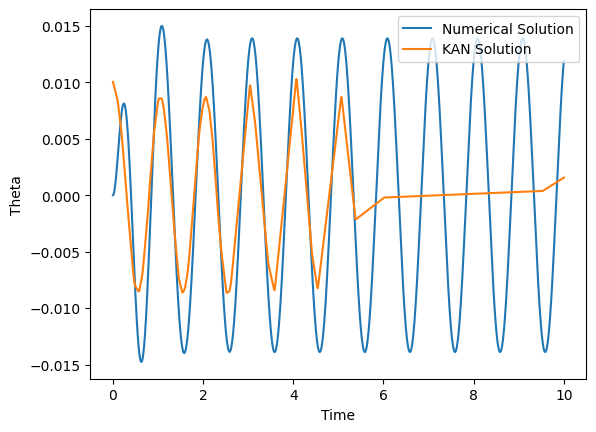

In [84]:

# Plot both the numerical and KAN solutions
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(t, y_kan, label='KAN Solution')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.legend()
plt.show()